<a href="https://colab.research.google.com/github/duvancatan/Time_Series_UdeA/blob/main/7_Johnson_jj_Forecast_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

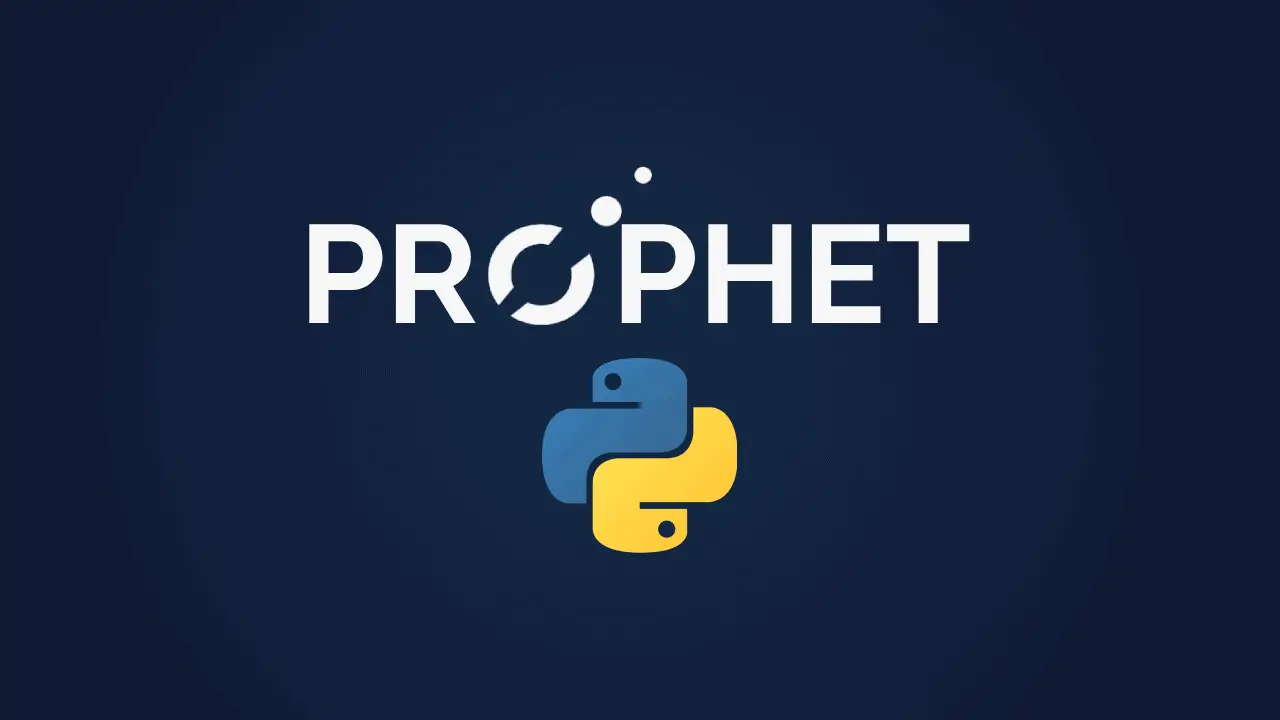

# **Metodología : PROPHET**
Prophet es un procedimiento para pronosticar datos de series temporales basado en un modelo aditivo donde las tendencias no lineales se ajustan a la estacionalidad anual, semanal y diaria, además de los efectos de las vacaciones. Funciona mejor con series temporales que tienen fuertes efectos estacionales y varias temporadas de datos históricos. Prophet es resistente a los datos faltantes y a los cambios en la tendencia y, por lo general, maneja bien los valores atípicos.

## **Características**:
1. Preciso y rápido: Prophet es preciso y rápido. Se utiliza en muchas aplicaciones de Facebook para producir pronósticos confiables para la planificación y el establecimiento de objetivos.
2. Completamente automático: Prophet es completamente automático. Obtendremos un pronóstico razonable sobre datos confusos sin esfuerzo manual.
3. Pronósticos ajustables: Prophet produce pronósticos ajustables. Incluye muchas posibilidades para que los usuarios modifiquen y ajusten los pronósticos. Podemos utilizar parámetros interpretables por humanos para mejorar el pronóstico agregando nuestro conocimiento del dominio.
4. Disponible en R o Python: podemos implementar el procedimiento Prophet en R o Python.
5. Maneja bien las variaciones estacionales: Prophet se adapta a la estacionalidad con múltiples períodos.
6. Robusto ante valores atípicos: es robusto ante valores atípicos. Maneja los valores atípicos eliminándolos.
7. Robusto ante datos faltantes: Prophet es resistente a datos faltantes.

## Instalación y carga de librerías

In [ ]:
# Importación de librerías #
from prophet import Prophet
from statsmodels.datasets import get_rdataset
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Descripción :

La metodología Prophet es planteada originalmente por Taylor y Letham (2018) [1]. Se utilizan tres componentes en el modelo: tendencia, estacionalidad y efecto de vacaciones (*hollidays*).

$$Y_t=g_t+s_t+ h_t+e_t$$

*   $g_t$ es la función de tendencia que modela cambios no periódicos en el valor de la serie de tiempo.
*   $s_t$ representa cambios periódicos (por ejemplo, estacionalidad semanal y anual).
*  $h_t$ representa los efectos de las vacaciones.

La especificacion Prophet es una clase de modelos de regresión con suavizadores (*smoothers*) potencialmente no lineales aplicados a la regresores

[1] Taylor, S. & Letham, Benjamin (2018). Forecasting at Scale. *The American Statistician*. (72)1, 37-45. https://doi.org/10.1080/00031305.2017.1380080

## Instalación de libraría para leer bases de datos de *R-Project*

In [ ]:
# Librería facilitar el acceso a conjuntos de datos utilizados en libros y cursos de estadística #
!pip install astsadata

In [ ]:
# Carga de libraría y de la Serie de ganacias de Johnson & Johnson #
from astsadata import jj

In [ ]:
# Visualización de datos crudos #
jj

In [ ]:
# Formateando las fechas e información #
jj.index = pd.PeriodIndex(jj.index, freq='Q')
jj['ds'] = jj.index.to_timestamp()
jj = jj.reset_index(drop=True).rename(columns={'value': 'y'})[['ds', 'y']]
jj

In [ ]:
# Dimensión #
jj.shape

In [ ]:
# Vista de los primeros datos #
jj.head()

In [ ]:
# Vista de los últimos datos #
jj.tail()

In [ ]:
# Visualización Gráfica #
plt.style.use('seaborn-v0_8-muted')

# Crear la figura
fig, ax = plt.subplots(figsize=(12, 5))

# Graficar la serie
ax.plot(jj['ds'], jj['y'], color='royalblue', linewidth=2, marker='o', label='Ganancias JJ')

# Títulos y etiquetas
ax.set_title('Ganancias Trimestrales de Johnson & Johnson', fontsize=16, fontweight='bold')
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Ganancias', fontsize=12)

# Formato del eje x para fechas
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))  # cada 2 años
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Cuadrícula y leyenda
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='upper left', fontsize=12)

# Bordes suaves
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# Definir días festivos (puedes ajustar según eventos relevantes) #
holidays = pd.DataFrame({
    'holiday': 'fin_año',
    'ds': pd.to_datetime([
        '1960-12-31', '1961-12-31', '1962-12-31', '1963-12-31',
        '1964-12-31', '1965-12-31', '1966-12-31'
    ]),
    'lower_window': 0,
    'upper_window': 1
})

In [ ]:
# Número de pasos a predecir #
h = 32  # 32 trimestres

In [ ]:
# Separar datos de entrenamiento y prueba #
train = jj.iloc[:-h]
test = jj.iloc[-h:]

In [ ]:
# Visuali¡zación de datos de entrenamiento #
train

In [ ]:
# Visuali¡zación de datos de prueba #
test

In [ ]:
# Crear y entrenar modelo con o sin Holidays #
#model = Prophet(holidays=holidays)
model = Prophet()
model.fit(train)

In [ ]:
# Generar fechas futuras #
future = model.make_future_dataframe(periods=h, freq='Q')
forecast = model.predict(future)

In [ ]:
# Evaluar pronóstico. Redondeamos las fechas al inicio de trimestre para garantizar merge #
forecast['ds'] = forecast['ds'].dt.to_period('Q').dt.to_timestamp('Q')
test['ds'] = test['ds'].dt.to_period('Q').dt.to_timestamp('Q')

In [ ]:
# Hacer merge para comparar #
pred = forecast[['ds', 'yhat']].merge(test, on='ds', how='inner')

In [ ]:
# Definición de Métricas a ser empleadas#

# MAPE (Mean Absolute Percentage Error):Mide el error porcentual promedio entre los valores reales y pronosticados
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# sMAPE (Symmetric Mean Absolute Percentage Error): Variante simétrica del MAPE que evita divisiones por cero y reduce el sesgo hacia valores grandes
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / denominator) * 100

In [ ]:
# Imprimir métricas #
print(f"MAPE: {mape(pred['y'], pred['yhat']):.2f}%")
print(f"sMAPE: {smape(pred['y'], pred['yhat']):.2f}%")

In [ ]:
# Asegurarnos de que 'pred' tenga las columnas 'ds', 'y' (reales), 'yhat' (pronosticados) #
plt.figure(figsize=(10, 5))

# Línea de los valores reales (test) #
plt.plot(pred['ds'], pred['y'], label='Valores reales (test)', marker='o')

# Línea de los valores pronosticados #
plt.plot(pred['ds'], pred['yhat'], label='Pronóstico (yhat)', marker='o')

# Opcional: Agregar el entrenamiento previo #
plt.plot(train['ds'], train['y'], label='Entrenamiento')#, alpha=0.5, linestyle='--')

# Mejoras visuales #
plt.title('Pronóstico con Prophet vs Valores reales')
plt.xlabel('Fecha')
plt.ylabel('Ganancias')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()